# Growth Model Classification

In this notebook, we will try to classify customers into similar groups based on their prediction trend or slope. This classification will help us to differentiate customers based on their growth potentials and identify the top most important customers that the business should be aware of.

In [ ]:
#!pip install seaborn
#!pip install mlflow

In [1]:
import os
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from math import ceil
from sklearn.cluster import KMeans
from sklearn import linear_model
from ipynb.fs.defs.helper_functions import (
    find_slope_and_median,
    create_cluster_and_label_based_on_centroids,
    list_account_with_labels,
    plot_time_series
)
import warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = "{:,.3f}".format

## Import Data

In [2]:
# Let's read the model predictions into a df
df_predictions = pd.read_csv('../data/processed/forecast_result_Q2-Q3_test.csv')
df_to_plot = df_predictions #later used for plotting

In [3]:
df_predictions.head(12)

,Unnamed: 0,account_name,month,tenure,actual_mnth_value$,predicted_mnth_value$,MAPE,sMAPE
0,0,00XX_E_MPCP_US,2012-01-01,1,3.200,NaN,NaN,NaN
1,1,00XX_E_MPCP_US,2012-02-01,2,3.800,NaN,NaN,NaN
2,2,00XX_E_MPCP_US,2012-03-01,3,2.500,NaN,NaN,NaN
3,3,00XX_E_MPCP_US,2012-04-01,4,3.100,NaN,NaN,NaN
4,4,00XX_E_MPCP_US,2012-05-01,5,4.600,NaN,NaN,NaN
5,5,00XX_E_MPCP_US,2012-06-01,6,2.500,NaN,NaN,NaN
6,6,00XX_E_MPCP_US,2012-07-01,7,2.500,NaN,NaN,NaN
7,7,00XX_E_MPCP_US,2012-08-01,8,3.200,NaN,NaN,NaN
8,8,00XX_E_MPCP_US,2012-09-01,9,3.000,NaN,NaN,NaN
9,9,00XX_E_MPCP_US,2012-10-01,10,4.200,NaN,NaN,NaN


In [4]:
len(df_predictions)

2250

Let's filter only the predicted values

In [5]:
result_predictions = df_predictions[(df_predictions['month'] >= '2015-04-01')]

In [6]:
result_predictions.head()

,Unnamed: 0,account_name,month,tenure,actual_mnth_value$,predicted_mnth_value$,MAPE,sMAPE
39,39,00XX_E_MPCP_US,2015-04-01,40,NaN,4.648,0.000,0.000
40,40,00XX_E_MPCP_US,2015-05-01,41,NaN,4.648,0.000,0.000
41,41,00XX_E_MPCP_US,2015-06-01,42,NaN,4.648,0.000,0.000
42,42,00XX_E_MPCP_US,2015-07-01,43,NaN,4.648,0.000,0.000
43,43,00XX_E_MPCP_US,2015-08-01,44,NaN,4.648,0.000,0.000


In [7]:
# Retain relevant columns
result_df = result_predictions[['account_name','tenure', 'month', 'predicted_mnth_value$']]
result_df.head(12)

,account_name,tenure,month,predicted_mnth_value$
39,00XX_E_MPCP_US,40,2015-04-01,4.648
40,00XX_E_MPCP_US,41,2015-05-01,4.648
41,00XX_E_MPCP_US,42,2015-06-01,4.648
42,00XX_E_MPCP_US,43,2015-07-01,4.648
43,00XX_E_MPCP_US,44,2015-08-01,4.648
44,00XX_E_MPCP_US,45,2015-09-01,4.648
84,00XX_E_MPCT_US,40,2015-04-01,4.648
85,00XX_E_MPCT_US,41,2015-05-01,4.648
86,00XX_E_MPCT_US,42,2015-06-01,4.648
87,00XX_E_MPCT_US,43,2015-07-01,4.648


## Calculate slope/trend of the predictions

We will now calculate the trend in the predictions for each customer i.e calculate their slope from their 6 month prediction curve

In [8]:
# convert the predicted monthly revenue to float type
result_df['predicted_mnth_value$'] = result_df['predicted_mnth_value$'].astype(float)
# convert month to ordinal date type
result_df['date_ordinal'] = pd.to_datetime(result_df['month']).map(dt.datetime.toordinal)
# Calculate the slope and median predicted monthly revenue for each customer prediction curve
slopes = result_df.groupby(['account_name']).apply(lambda x: find_slope_and_median(x)).reset_index()
result = slopes
# Calculate the final tenure of each account
tenures = result_df.groupby('account_name')['tenure'].max().reset_index()
# Calculate the avg. revenue of each account (over 6 month prediction window)
rev = result_df.groupby('account_name')['predicted_mnth_value$'].mean().reset_index()
result.columns = ['account_name', 'slope', 'median_predicted_value']
result['tenure'] = tenures['tenure']
result['avg_revenue'] = rev['predicted_mnth_value$']
# convert the slope value to float
result['slope'] = result['slope'].astype(float)
result.head()

,account_name,slope,median_predicted_value,tenure,avg_revenue
0,00XX_E_MPCP_US,0.000,4.648,45,4.648
1,00XX_E_MPCT_US,0.000,4.648,45,4.648
2,00XX_E_MPCV_US,0.000,0.000,45,0.000
3,00XX_E_P_US,0.002,5.934,45,5.934
4,00XX_E_T_US,0.002,5.962,45,5.962


In [9]:
#scaling the slope values
scaler = StandardScaler()
result['slope_scaled'] = scaler.fit_transform(result[['slope']])

# K-Means Clustering for Classification

In order to group customers with similar slope values, we will apply k-means clustering to the input features, which in this case are the slopes. To calculate the slopes and assign labels to the resulting clusters based on centroid values, we will utilize a function called "create_cluster_and_label_based_on_centroids." To use this function, you need to provide the dataframe and specify the number of slopes you want to identify. Additional details about this function can be found in the helper function notebook.

In our analysis, we utilize a systematic approach to segment the clusters into three distinct groups, leveraging their individual slope values. These slope values serve as crucial indicators of the forecasted value trends associated with each cluster. By examining the slopes, we gain valuable insights into how the accounts' value is projected to evolve over time.

Once we have identified the slope values for each cluster, we proceed to evaluate the accounts potential within the dataset. To accomplish this, we assign accounts to different levels: low, medium, high based on the corresponding slope measurements. This categorization allows us to effectively assess the varying degrees of potential accounts exhibited by each group.

## Clustering

In [10]:
result = create_cluster_and_label_based_on_centroids(result, 3)
result.head()

,account_name,slope,median_predicted_value,tenure,avg_revenue,slope_scaled,cluster_label
0,00XX_E_MPCP_US,0.000,4.648,45,4.648,-0.151,medium
1,00XX_E_MPCT_US,0.000,4.648,45,4.648,-0.151,medium
2,00XX_E_MPCV_US,0.000,0.000,45,0.000,-0.151,medium
3,00XX_E_P_US,0.002,5.934,45,5.934,-0.149,medium
4,00XX_E_T_US,0.002,5.962,45,5.962,-0.149,medium


<Axes: xlabel='slope_scaled', ylabel='median_predicted_value'>

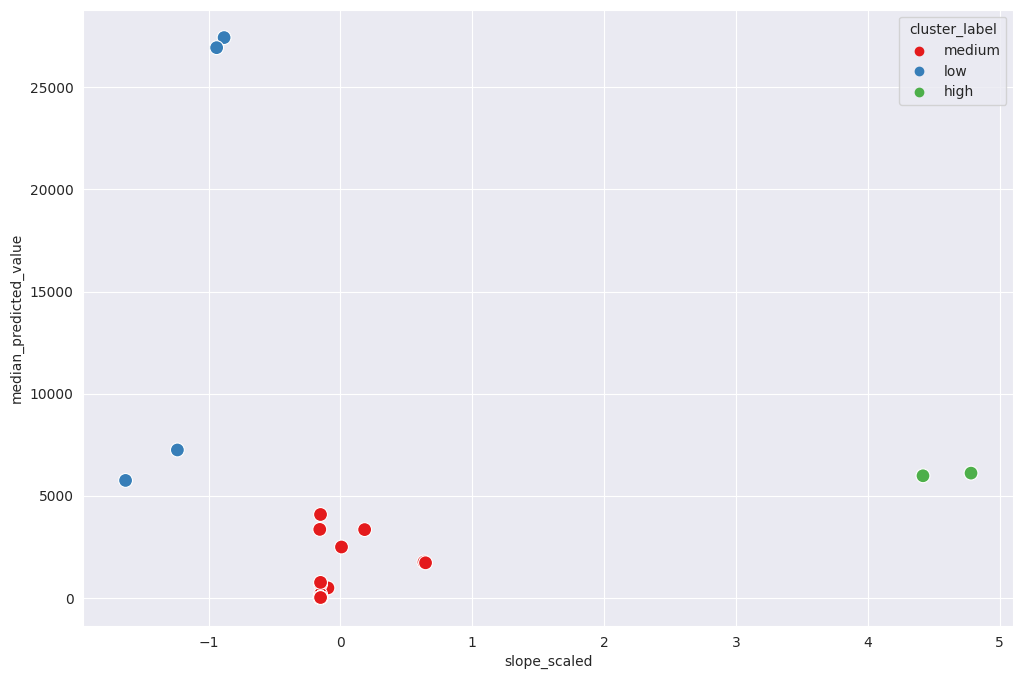

In [11]:
# Visualization plot
fig = plt.gcf()
fig.set_size_inches(12,8)
sns.set_style("darkgrid")
sns.scatterplot(data=result, x="slope_scaled", y="median_predicted_value", hue='cluster_label', palette="Set1", s=100)


In the above plot, we try to visualize the 3 different cluster groups by plotting their slope values (along x-axis) and their median predicted value (along y-axis). 
To identify individual accounts with high potential, we utilize the function "list_account_with_labels" to filter the dataset and extract the relevant accounts falling under this specific category. Subsequently, we proceed to visualize the time series data for the selected account using the function "plot_time_series". To generate the desired plot, we need to provide the account name as input parameters to the function. This allows us to gain valuable insights into the revenue trends and patterns for the given account, facilitating a comprehensive analysis of its performance over time.

For example, list accounts with "high" potential. 

In [12]:
list_account_with_labels(result, "high")

,account_name,slope,median_predicted_value,tenure,avg_revenue,slope_scaled,cluster_label
31,03XX_T_US,4.746,"6,100.147",45,"5,971.211",4.783,high
32,03XX_V_US,4.396,"5,969.513",45,"5,861.435",4.419,high


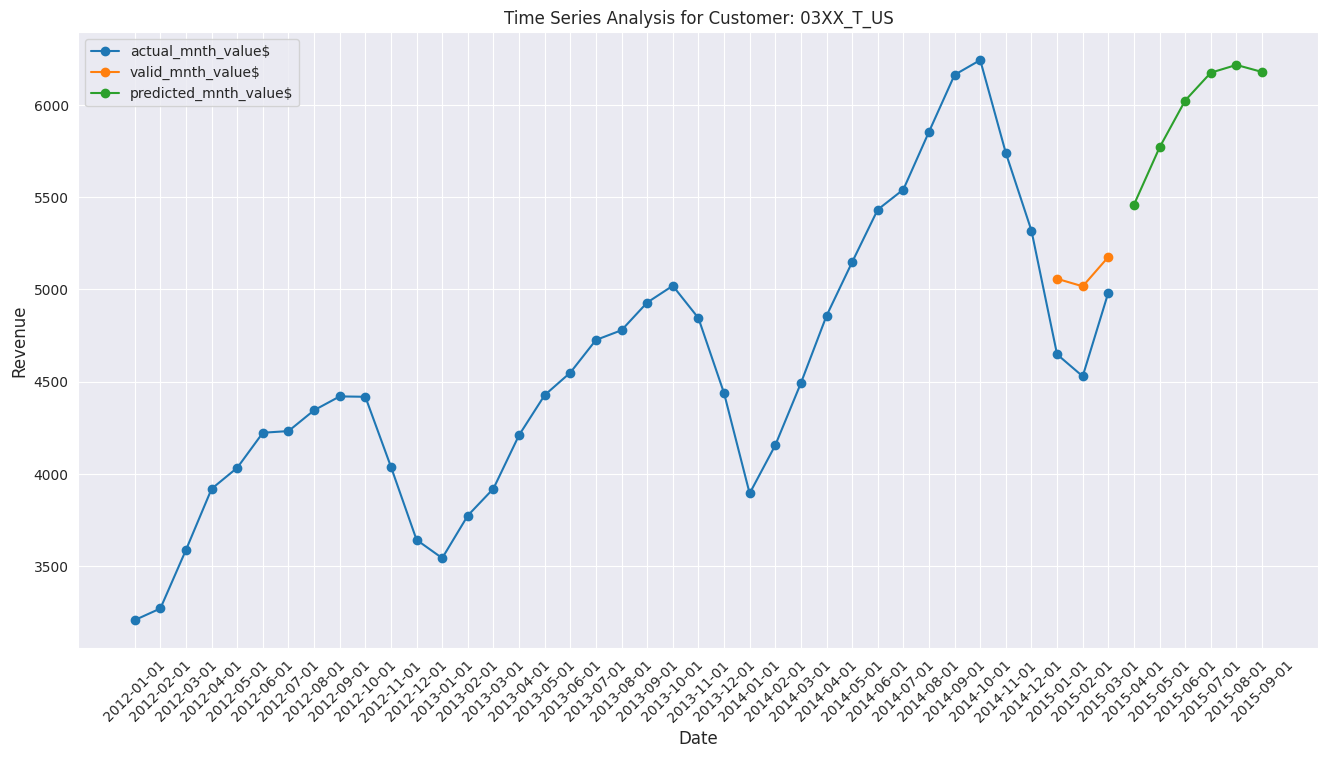

In [13]:
plot_time_series(df_to_plot,'03XX_T_US' )

The time series plot displays monthly revenue over time. The x-axis represents the dates, while the y-axis represents the revenue. The blue line represents the actual monthly revenue, which serves as the training data. The orange line represents the validation data. Additionally, there are green points on the plot that correspond to forecasted revenue values.

By examining the slope values of the green points, specifically on the validation plot, we have identified this account as a high potential account. This indicates a strong likelihood of revenue growth for this type of account in the next six months.

In [14]:
# Saving the classification report
result.to_csv('../data/processed/classification_result.csv', index=False)

# Conclusion

In conclusion, we successfully analyzed different accounts based on their tenure and monthly revenue, resulting in the following accomplishments:

- Applied k-means clustering to group customers based on slope values.
- Divided the customers into different potential groups.
- Filtered the dataset to focus on high-potential customers.
- Visualized revenue trends over time for individual accounts.

These accomplishments highlight our ability to leverage data-driven techniques to gain insights into customer behavior and revenue patterns. By dividing customers into different potential groups and visualizing revenue trends, we provide actionable recommendations for targeted strategies and personalized approaches.